Adapted from book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python) by François Chollet. The original code can be found [here](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb).

Download the already prepared dataset. See `Cats and dogs preprocessing.ipynb` how to prepare custom dataset.

In [1]:
!wget https://courses.cs.ut.ee/2019/nn/spring/uploads/Main/cats_and_dogs_small_train.zip
!wget https://courses.cs.ut.ee/2019/nn/spring/uploads/Main/cats_and_dogs_small_valtest.zip

--2019-04-14 20:03:15--  https://courses.cs.ut.ee/2019/nn/spring/uploads/Main/cats_and_dogs_small_train.zip
Resolving courses.cs.ut.ee (courses.cs.ut.ee)... 193.40.36.55, 193.40.36.57
Connecting to courses.cs.ut.ee (courses.cs.ut.ee)|193.40.36.55|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /LTAT.02.001/2019_spring/uploads/Main/cats_and_dogs_small_train.zip [following]
--2019-04-14 20:03:15--  https://courses.cs.ut.ee/LTAT.02.001/2019_spring/uploads/Main/cats_and_dogs_small_train.zip
Reusing existing connection to courses.cs.ut.ee:443.
HTTP request sent, awaiting response... 200 OK
Length: 45624410 (44M) [application/zip]
Saving to: ‘cats_and_dogs_small_train.zip’

cats_and_dogs_small 100%[===================>]  43,51M  1,53MB/s    in 34s     

2019-04-14 20:03:50 (1,26 MB/s) - ‘cats_and_dogs_small_train.zip’ saved [45624410/45624410]

--2019-04-14 20:03:50--  https://courses.cs.ut.ee/2019/nn/spring/uploads/Main/cats_and_dogs_small_valtest.

In [2]:
!unzip -q cats_and_dogs_small_train.zip
!unzip -q cats_and_dogs_small_valtest.zip

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image

from keras import models
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Dataset directories
train_dir = 'cats_and_dogs_small/train'
validation_dir = 'cats_and_dogs_small/validation'
test_dir = 'cats_and_dogs_small/test'

# Create ImageDataGenerator for training
train_datagen = ImageDataGenerator(
    # Normalize inputs to the network
    preprocessing_function=preprocess_input,
    # Use data augmentation during training
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)
# Skip data augmentation during testing
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Read training dataset
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        # Read 32 images at once
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Read validation dataset
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)


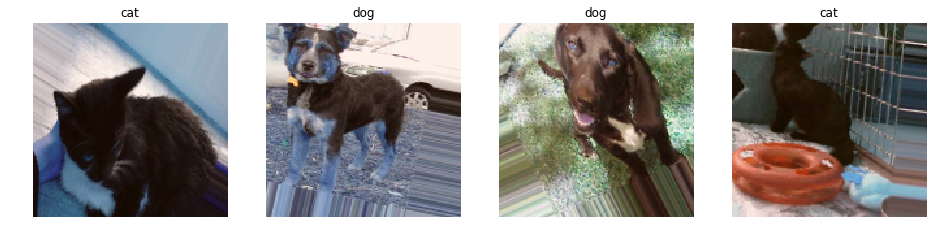

In [3]:
# Show first 4 images from the first training mini-batch
# Notice the data augmentation artifacts!
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    plt.figure(figsize=(16, 8))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(image.array_to_img(data_batch[i]))
        plt.title("dog" if labels_batch[i] == 1 else "cat")
        plt.axis('off')
    break

In [4]:
# Load pre-trained model without classification layers (include_top=False)
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
bloc

In [5]:
# Add our own classification layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Freeze the pre-trained network
# Notice how the number of trainable parameters changes!
conv_base.trainable = False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
# Use binary cross-entropy together with sigmoid activation
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.00005),
              metrics=['acc'])

In [8]:
# Train the classification layer
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
100/100 [==============================] - 33s 325ms/step - loss: 1.3375 - acc: 0.8416 - val_loss: 0.5269 - val_acc: 0.9454
Epoch 2/10
100/100 [==============================] - 27s 272ms/step - loss: 0.6437 - acc: 0.9212 - val_loss: 0.3922 - val_acc: 0.9562
Epoch 3/10
100/100 [==============================] - 27s 274ms/step - loss: 0.4616 - acc: 0.9366 - val_loss: 0.3824 - val_acc: 0.9619
Epoch 4/10
100/100 [==============================] - 29s 293ms/step - loss: 0.4788 - acc: 0.9428 - val_loss: 0.2969 - val_acc: 0.9691
Epoch 5/10
100/100 [==============================] - 28s 284ms/step - loss: 0.4165 - acc: 0.9459 - val_loss: 0.3478 - val_acc: 0.9664
Epoch 6/10
100/100 [==============================] - 33s 334ms/step - loss: 0.3571 - acc: 0.9512 - val_loss: 0.5049 - val_acc: 0.9510
Epoch 7/10
100/100 [==============================] - 32s 322ms/step - loss: 0.3544 - acc: 0.9559 - val_loss: 0.3343 - val_acc: 0.9651
Epoch 8

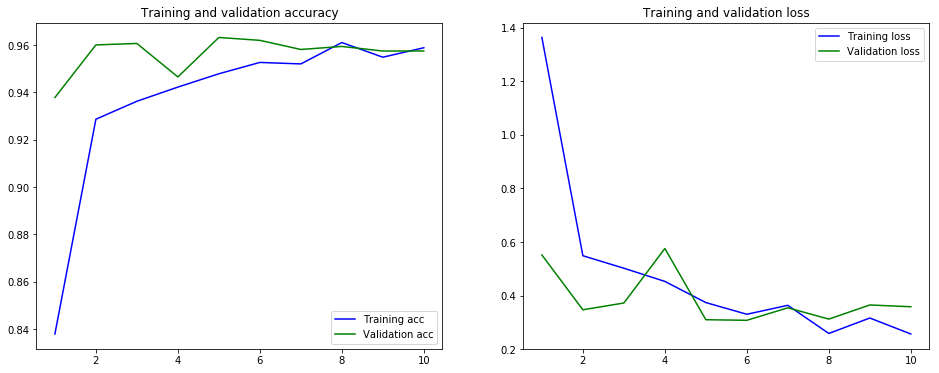

In [13]:
# Plot learning curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
# Freeze all layers up to a specific one
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    layer.trainable = set_trainable

# Need to recompile after changing trainable layers
model.compile(loss='binary_crossentropy',
      optimizer=optimizers.Adam(lr=0.00005),
      metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [10]:
# Fine-tune also convolutional layers
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      initial_epoch=10,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 11/20
100/100 [==============================] - 33s 326ms/step - loss: 0.3750 - acc: 0.9450 - val_loss: 0.3249 - val_acc: 0.9530
Epoch 12/20
100/100 [==============================] - 32s 317ms/step - loss: 0.2449 - acc: 0.9291 - val_loss: 0.2028 - val_acc: 0.9414
Epoch 13/20
100/100 [==============================] - 32s 319ms/step - loss: 0.1409 - acc: 0.9484 - val_loss: 0.1742 - val_acc: 0.9626
Epoch 14/20
100/100 [==============================] - 32s 319ms/step - loss: 0.0920 - acc: 0.9669 - val_loss: 0.3217 - val_acc: 0.9523
Epoch 15/20
100/100 [==============================] - 40s 396ms/step - loss: 0.1383 - acc: 0.9631 - val_loss: 0.1893 - val_acc: 0.9492
Epoch 16/20
100/100 [==============================] - 32s 318ms/step - loss: 0.1090 - acc: 0.9641 - val_loss: 0.2231 - val_acc: 0.9562
Epoch 17/20
100/100 [==============================] - 35s 351ms/step - loss: 0.0715 - acc: 0.9784 - val_loss: 0.1395 - val_acc: 0.9695
Epoch 18/20
100/100 [===========================

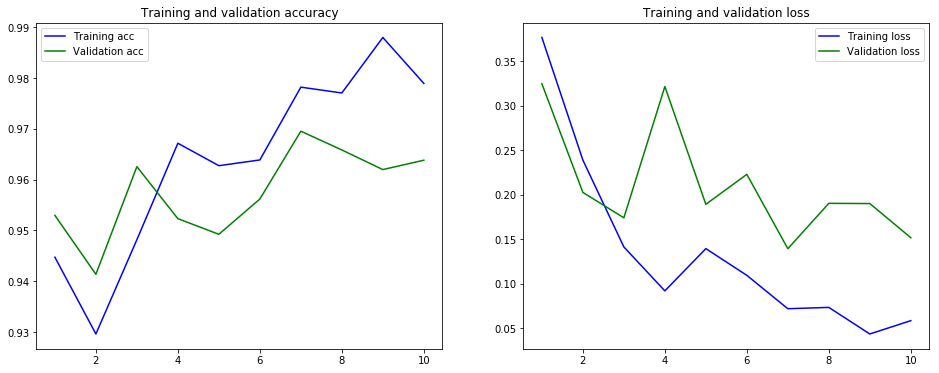

In [11]:
# Plot learning curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
# Test the model on test set
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9639999961853027
